In [53]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Flatten, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

# Data Input and Model Creation

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
#Concatenate positive and negative samples
trainFull = pd.read_csv("drive/MyDrive/PreprocessedData/trainFull.csv")
testFull = pd.read_csv("drive/MyDrive/PreprocessedData/testFull.csv")
    
#Randomize samples
trainFull = trainFull.sample(len(trainFull))
testFull = testFull.sample(len(testFull))

#Randomize samples
trainFull = trainFull.sample(len(trainFull))
testFull = testFull.sample(len(testFull))


In [14]:
#Reduce features and extract labels
trainX = trainFull.iloc[:,:-2]
trainY = trainFull.iloc[:,-1]
testX = testFull.iloc[:,:-2]
testY = testFull.iloc[:,-1]
#Standard scale training data
trainScaler = StandardScaler()
trainScaler.fit(trainX)
trainX = trainScaler.transform(trainX)

#Export standard scale
#dump(trainScaler, 'standardScaler.bin', compress=True)

#Standard scale testing data
testScaler = StandardScaler()
testScaler.fit(testX)
testX = testScaler.transform(testX)

#Reshape data to 3D for CNN
trainX = trainX[..., None]
trainY = trainY[..., None]
testX = testX[..., None]
testY = testY[..., None]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [15]:
"""
This method contains the architecture for the CNN used.
It uses tensorflow sequential as the basis to crease the model.

@param numConvFilters: number of convolutional filters in the 2nd hidden layer. We recommend >32 to upscale.
@param dropout: fraction of nodes dropped out of the Max Pooling layer.
@param numDenseNodes: number of dense nodes in the feed forward layer.

Recommended:
numConvFilters = 242
dropout = .215
numDenseNodes = 190

"""
def newModel(numConvFilters = 242, dropout = .215, numDenseNodes = 190):
    #Create new sequential model
    model = Sequential()

    #Add 1D Convolutional layers
    model.add((Conv1D(filters=32, kernel_size=3, activation='relu')))
    model.add((Conv1D(filters=numConvFilters, kernel_size=3, activation='relu')))
    #Add Max Pooling layer
    model.add((MaxPooling1D(pool_size=2)))
    #Apply dropout
    model.add(Dropout(dropout))
    #Flatten model
    model.add(Flatten())
    #Add fully connected dense layer
    model.add(Dense(numDenseNodes, activation='sigmoid'))
    #Add output node
    model.add(Dense(1, activation='sigmoid'))
    
    #Define optimizer
    adam = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #Compile model
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve='PR'),                                                                                         tf.keras.metrics.RecallAtPrecision(0.8)])
    return model

In [16]:
model = newModel()
model.fit(trainX, trainY, epochs = 30, batch_size=20, verbose = 1)

Epoch 1/30
758/758 [==============================] - 24s 29ms/step - loss: 0.5752 - auc_1: 0.7669 - recall_at_precision: 0.4145
Epoch 2/30
758/758 [==============================] - 22s 29ms/step - loss: 0.5236 - auc_1: 0.8202 - recall_at_precision: 0.5859
Epoch 3/30
758/758 [==============================] - 22s 29ms/step - loss: 0.5076 - auc_1: 0.8328 - recall_at_precision: 0.6117
Epoch 4/30
758/758 [==============================] - 22s 29ms/step - loss: 0.4930 - auc_1: 0.8442 - recall_at_precision: 0.6576
Epoch 5/30
758/758 [==============================] - 22s 29ms/step - loss: 0.4817 - auc_1: 0.8527 - recall_at_precision: 0.6721
Epoch 6/30
758/758 [==============================] - 23s 31ms/step - loss: 0.4723 - auc_1: 0.8586 - recall_at_precision: 0.6951
Epoch 7/30
758/758 [==============================] - 22s 29ms/step - loss: 0.4579 - auc_1: 0.8687 - recall_at_precision: 0.7186
Epoch 8/30
758/758 [==============================] - 22s 29ms/step - loss: 0.4500 - auc_1: 0.873

In [21]:
y_scores

NameError: ignored

# Validation and Analysis 

In [89]:
#create confusion Matrix
def confusionMatrix(model, testX, testY):
    pred = model.predict(testX)
    predy = []
    for i in range(0,len(pred)):
        if pred[i] >= .5:
            predy.append(1)
        else:
            predy.append(0)
        
    print(confusion_matrix(testY,predy))
    return(testY,predy)
    
#Calculates our model metrics
def modelMetrics(testX, testY, model):
    y_scores = model.predict(testX)
    predy = []
    for i in range(0,len(y_scores)):
        if y_scores[i] >= .5:
            predy.append(1)
        else:
            predy.append(0)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    rec80 = np.max(recall[precision >= .8])
    print("Recall at 80% Precision: " +str(rec80))
    aucPR = auc(recall, precision)
    print("PR-AUC: " + str(aucPR))    
    precisionscore = precision_score(testY, predy, average="macro")
    print("Precision:"+str(precisionscore))
    f1 = f1_score(testY, predy, average="macro")
    print("F1:"+str(f1))
    return rec80, aucPR

#plots a PR curve
def PRplot(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    plt.plot(recall, precision)
    plt.title("PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

Recall at 80% Precision: 0.8965699208443272
PR-AUC: 0.9210022751766479
Precision:0.8467297512264895
F1:0.8466987626055509
[[1596  299]
 [ 282 1613]]


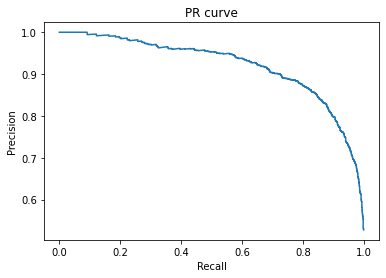

In [90]:
modelMetrics(testX, testY, model)
y_target,y_cnn=confusionMatrix(model, testX, testY)
PRplot(testX, testY, model)

OTHER MODELS

RF STARTS

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split,KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
import numpy as np
# from fastcore.all import *
from collections import defaultdict
# import optuna
from scipy.cluster import hierarchy as hc
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from mlxtend.evaluate import mcnemar_table,mcnemar

In [92]:
trainX_Org = trainFull.iloc[:,:-2]
trainY_Org = trainFull.iloc[:,-1]

testX_Org = testFull.iloc[:,:-2]
testY_Org = testFull.iloc[:,-1]

#Standard scale training data
trainScaler = StandardScaler()
trainScaler.fit(trainX_Org)
trainX_Org = trainScaler.transform(trainX_Org)

#Standard scale testing data
testScaler = StandardScaler()
testScaler.fit(testX_Org)
testX_Org = testScaler.transform(testX_Org)

In [93]:
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_features=0.5,
    min_samples_leaf=4,
    oob_score=True,
    n_jobs=-1,
)
rf_clf.fit(trainX_Org ,trainY_Org)


RandomForestClassifier(max_features=0.5, min_samples_leaf=4, n_jobs=-1,
                       oob_score=True)

Recall at 80% Precision: 0.7683377308707124
PR-AUC: 0.8599948804788721
Precision:0.810732713386194
F1:0.8083948674439747
[[1609  286]
 [ 439 1456]]


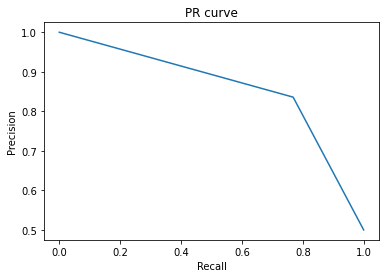

In [94]:
modelMetrics(testX_Org, testY_Org, rf_clf)
_,y_rf=confusionMatrix(rf_clf, testX_Org, testY_Org)
PRplot(testX_Org, testY_Org, rf_clf)

RF ENDS

SVM STARTS

In [95]:
from sklearn import svm
svm_clf = svm.SVC()
svm_clf.fit(trainX_Org, trainY_Org)


SVC()

Recall at 80% Precision: 0.0
PR-AUC: 0.8230041861031947
Precision:0.7637661140647805
F1:0.7629021597135839
[[1495  400]
 [ 498 1397]]


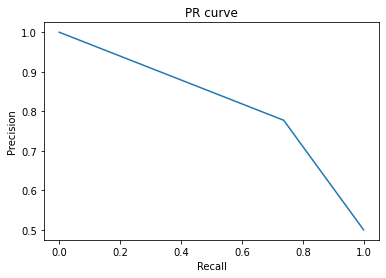

In [96]:
modelMetrics(testX_Org, testY_Org, svm_clf)
_,y_svm=confusionMatrix(svm_clf, testX_Org, testY_Org)
PRplot(testX_Org, testY_Org, svm_clf)

NAIVE BAYSE

In [97]:
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
nb_clf.fit(trainX_Org, trainY_Org)

GaussianNB()

Recall at 80% Precision: 0.0
PR-AUC: 0.7202914233197948
Precision:0.6548366723199774
F1:0.6256997917004204
[[1531  364]
 [1013  882]]


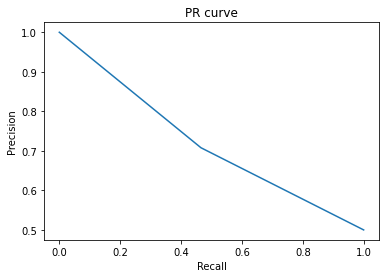

In [98]:
modelMetrics(testX_Org, testY_Org, nb_clf)
_,y_nb=confusionMatrix(nb_clf, testX_Org, testY_Org)
PRplot(testX_Org, testY_Org, nb_clf)

Logistic Regression

In [99]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(solver = 'saga')
lr_clf.fit(trainX_Org, trainY_Org)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(solver='saga')

Recall at 80% Precision: 0.0
PR-AUC: 0.7888269279729667
Precision:0.7193052172011922
F1:0.7188987105631365
[[1398  497]
 [ 568 1327]]


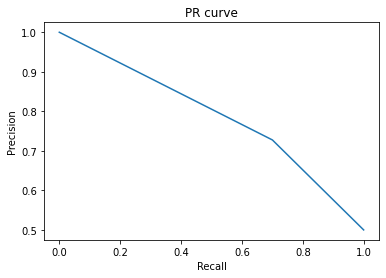

In [100]:
modelMetrics(testX_Org, testY_Org, lr_clf)
_,y_lr=confusionMatrix(lr_clf, testX_Org, testY_Org)
PRplot(testX_Org, testY_Org, lr_clf)

Analysis

STATISTICAL TESTS

In [ ]:
def McNemarsTest(model1_name,model2_name,actual,model1_pred,model2_pred):
  print('==================================================')
  print(f"{model1_name} v/s {model2_name}\n")
  actual = actual.reshape(-1)
  model1_pred = np.array(model1_pred)
  model2_pred = np.array(model2_pred)
  contingency_table = mcnemar_table(y_target=actual, y_model1=model1_pred,y_model2=model2_pred)
  print(pd.DataFrame(contingency_table,columns=[model1_name+" Correct",model1_name+" Incorrect"],index=[model2_name+" Correct",model2_name+" Incorrect"]))
  statistic,pvalue=mcnemar(contingency_table,exact=True)
  print(f"\nChi-Squared Test Statistic = {statistic}")
  print(f"p-value = {pvalue}")
  print(f"Odds Ratio = {contingency_table[1][0]/contingency_table[0][1]}\n")
  print('==================================================')

In [ ]:
print("Statistical McNemar's Test Results for all Classifier Comparisons\n")
McNemarsTest("CNN","Random Forest",y_target,y_cnn,y_rf)
McNemarsTest("CNN","SVM",y_target,y_cnn,y_svm)
McNemarsTest("CNN","Naive Bayes",y_target,y_cnn,y_nb)
McNemarsTest("CNN","Logistic Regression",y_target,y_cnn,y_lr)


Statistical McNemar's Test Results for all Classifier Comparisons

CNN v/s Random Forest

                         CNN Correct  CNN Incorrect
Random Forest Correct           2781            264
Random Forest Incorrect          429            316

Chi-Squared Test Statistic = 264
p-value = 3.8805116512521595e-10
Odds Ratio = 1.625

CNN v/s SVM

               CNN Correct  CNN Incorrect
SVM Correct           2639            254
SVM Incorrect          571            326

Chi-Squared Test Statistic = 254
p-value = 7.771010505950436e-29
Odds Ratio = 2.248031496062992

CNN v/s Naive Bayes

                       CNN Correct  CNN Incorrect
Naive Bayes Correct           2092            321
Naive Bayes Incorrect         1118            259

Chi-Squared Test Statistic = 321
p-value = 2.3506679932719145e-103
Odds Ratio = 3.4828660436137073

CNN v/s Logistic Regression

                               CNN Correct  CNN Incorrect
Logistic Regression Correct           2441            285
Logistic Regr